# About tasty and healthy food
**Project Description:** TripAdvisor rating prediction of european restaurants.

**Goal:** To help to estimate rating.

**Objectives:** Create model to predict restaurant rating.

**Dataset Description:** Dataset consists of info of 40 000 restaurants into train set and 10 000 restaurants into test set.

Dataset features:
1. Restaurant_id — identification number of restaurant / restaurant network;
2. City — city where the restaurant is located;
3. Cuisine Style — cuisine or cuisines, which include dishes offered in the restaurant;
4. Ranking — the spot that this restaurant takes among all the restaurants in its city;
5. Rating — restaurant rating according to TripAdvisor (target variable);
6. Price Range — restaurant price range;
7. Number of Reviews — restaurant reviews amount;
8. Reviews — data of two reviews displayed on the restaurant website;
9. URL_TA — restaurant URL page on TripAdvosor;
10. ID_TA — restaurant identifier in TripAdvisor database.

In [128]:
import os
import re
import math
from io import StringIO
from collections import Counter
from itertools import chain, combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy.stats import ttest_ind

pd.options.display.max_columns = 40

In [129]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
print()        
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
print()        
for dirname, _, filenames in os.walk('/kaggle/temp'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv

/kaggle/working/requirements.txt
/kaggle/working/submission.csv
/kaggle/working/__notebook_source__.ipynb



In [130]:
# Set random seed
RANDOM_SEED = 42

In [131]:
# Save requirements
!pip freeze > requirements.txt

# Data preparing
## Collecting and formating

In [132]:
def format_price_range(val):
    """Convert dollar signs of Price_range feature to numbers"""
    val = val.replace('$$$$', '3')
    val = val.replace('$$ - $$$', '2')
    val = val.replace('$', '1')
    if val == '':
        return np.nan
    return float(val)


def format_id_ta(val):
    """Convert ID_TA feature to numbers"""
    return int(val[1:])


def collect_data(path):
    """Read train and test datasets and join them"""
    # Datasets reading
    df_train = pd.read_csv(path+'main_task.csv', converters={'Price Range': format_price_range, 'ID_TA': format_id_ta})
    df_test = pd.read_csv(path+'kaggle_task.csv', converters={'Price Range': format_price_range, 'ID_TA': format_id_ta})
    sample_submission = pd.read_csv(path+'sample_submission.csv')

    # Join train and test datasets
    df_train['sample'] = 1 # Train flag = 1
    df_test['sample'] = 0 # Train flag = 0
    df_test['Rating'] = 0 # Fill target variable of the test dataset with zeros
    df_join = df_train.append(df_test, sort=False).reset_index(drop=True) # Join
    
    return (df_train, df_test, df_join, sample_submission)


def format_dataset(df):
    """Format dataset"""
    # Rename columns
    df.rename(columns={
        'Cuisine Style': 'Cuisine',
        'Price Range': 'Price_range',
        'Number of Reviews': 'Reviews_num',
    }, inplace=True)

    # Split 'Cuisine' feature
    df['Cuisine'] = df['Cuisine'].str.strip('[]').str.replace("',\s'", '|').str.replace("'", '')

    # Split 'Reviews' feature
    df['Reviews'] = df['Reviews'].str.lower().replace('[[], []]', np.nan, regex=False)
    df[['Reviews', 'Rev_day1']] = df['Reviews'].str.strip('[]').str.split('],\s\[', expand=True)
    df[['Review1', 'Review2']] = df['Reviews'].str.strip("'\"").str.split("['\"],\s['\"]", expand=True)
    df['Review1'] = df['Review1'].str.replace('[().,!?@#$%^&*:;]', ' ').str.replace("['\"]", '')
    df['Review2'] = df['Review2'].str.replace('[().,!?@#$%^&*:;]', ' ').str.replace("['\"]", '')
    df.drop(['Reviews'], axis=1, inplace=True)
    df[['Rev_day1', 'Rev_day2']] = df['Rev_day1'].str.strip("'").str.split("',\s'", expand=True)
    df['Rev_day1'] = pd.to_datetime(df['Rev_day1'])
    df['Rev_day2'] = pd.to_datetime(df['Rev_day2'])
    df[['Rev_day1', 'Rev_day2']] =  df[['Rev_day1', 'Rev_day2']].max() - df[['Rev_day1', 'Rev_day2']]
    df['Rev_day1'] = df['Rev_day1'].dt.days
    df['Rev_day2'] = df['Rev_day2'].dt.days

    # Swap date and review columns if date1 < date2
    idx = (df['Rev_day1'] < df['Rev_day2'])
    df.loc[idx, ['Rev_day1', 'Rev_day2']] = df.loc[idx, ['Rev_day2', 'Rev_day1']].values
    df.loc[idx, ['Review1', 'Review2']] = df.loc[idx, ['Review2', 'Review1']].values


def check_features_format(df):
    """Check format of dataframe features"""
    # Features to check
    cols_regex = {
        'Restaurant_id': 'id_\d+',
    }

    # Check and print result
    for key, val in cols_regex.items():
        a = df[key].str.match(val).sum()
        b = df[key].count()
        print(f"'{key}' feature matches the regex format '{val}' for {a} of {b} rows")

## Feature engineering

In [133]:
def create_new_features(df):
    # Create feature of difference between two review dates
    df['Rev_day_delta'] = df['Rev_day1'] - df['Rev_day2']

    # Create feature of number of reviews on the site
    df['Site_rev_num'] = 0
    df['Site_rev_num'] += df['Rev_day1'].notna()
    df['Site_rev_num'] += df['Rev_day2'].notna()
    
    # Create feature of average site review length
    df['Site_rev_len'] = df['Review1'].str.count('\w+') + df['Review2'].str.count('\w+')
    idx = df['Site_rev_num'] > 0
    df.loc[idx, 'Site_rev_len'] /= df.loc[idx, 'Site_rev_num']
    df['Site_rev_len'].fillna(0, inplace=True)
    
    # Create feature of cuisine number
    df.loc[df['Cuisine'].notna(), 'Cuisine_num'] = df.loc[df['Cuisine'].notna(), 'Cuisine'].apply(lambda x: len(x.split('|')))
        
    # Create feature of country
    country = {
        'London': 'England',
        'Paris': 'France',
        'Madrid': 'Spain',
        'Barcelona': 'Spain',
        'Berlin': 'Germany',
        'Milan': 'Italy',
        'Rome': 'Italy',
        'Prague': 'Czech Republic',
        'Lisbon': 'Portugal',
        'Vienna': 'Austria',
        'Amsterdam': 'Netherlands',
        'Brussels': 'Belgium',
        'Hamburg': 'Germany',
        'Munich': 'Germany',
        'Lyon': 'France',
        'Stockholm': 'Sweden',
        'Budapest': 'Hungary',
        'Warsaw': 'Poland',
        'Dublin': 'Ireland',
        'Copenhagen': 'Denmark',
        'Athens': 'Greece',
        'Edinburgh': 'Scotland',
        'Zurich': 'Switzerland',
        'Oporto': 'Portugal',
        'Geneva': 'Switzerland',
        'Krakow': 'Poland',
        'Oslo': 'Norway',
        'Helsinki': 'Finland',
        'Bratislava': 'Slovakia',
        'Luxembourg': 'Luxembourg',
        'Ljubljana': 'Slovenia',
    }
    df['Country'] = df['City'].map(country)
    
    # Create feature of city population (in millions)
    population = {
        'London': 8.567, 
        'Paris': 9.904, 
        'Madrid': 5.567,
        'Barcelona': 4.920,
        'Berlin': 3.406,
        'Milan': 2.945,
        'Rome': 3.339,
        'Prague': 1.162,
        'Lisbon': 2.812,
        'Vienna': 2.400,
        'Amsterdam': 1.031,
        'Brussels': 1.743,
        'Hamburg': 1.757,
        'Munich': 1.275,
        'Lyon': 1.423,
        'Stockholm': 1.264,
        'Budapest': 1.679,
        'Warsaw': 1.707,
        'Dublin': 1.059,
        'Copenhagen': 1.085,
        'Athens': 3.242,
        'Edinburgh': 0.505,
        'Zurich': 1.108,
        'Oporto': 1.337,
        'Geneva': 1.240,
        'Krakow': 0.756,
        'Oslo': 0.835,
        'Helsinki': 1.115,
        'Bratislava': 0.424,
        'Luxembourg': 0.107,
        'Ljubljana': 0.315,
    }
    df['Population'] = df['City'].map(population)
    
    # Create feature of capital city
    is_capital = {
        'London': 1, 
        'Paris': 1, 
        'Madrid': 1,
        'Barcelona': 0,
        'Berlin': 1,
        'Milan': 0,
        'Rome': 1,
        'Prague': 1,
        'Lisbon': 1,
        'Vienna': 1,
        'Amsterdam': 1,
        'Brussels': 1,
        'Hamburg': 0,
        'Munich': 0,
        'Lyon': 0,
        'Stockholm': 1,
        'Budapest': 1,
        'Warsaw': 1,
        'Dublin': 1,
        'Copenhagen': 1,
        'Athens': 1,
        'Edinburgh': 0,
        'Zurich': 0,
        'Oporto': 0,
        'Geneva': 0,
        'Krakow': 0,
        'Oslo': 1,
        'Helsinki': 1,
        'Bratislava': 1,
        'Luxembourg': 1,
        'Ljubljana': 1,
    }
    df['Is_capital'] = df['City'].map(is_capital)

    # Create features of visitors per year (in millions)
    visiros_euromonitor = {
        'London': 19.233, 
        'Paris': 17.560, 
        'Madrid': 5.440,
        'Barcelona': 6.714,
        'Berlin': 5.959,
        'Milan': 6.481,
        'Rome': 10.065,
        'Prague': 8.948,
        'Lisbon': 3.539,
        'Vienna': 6.410,
        'Amsterdam': 8.354,
        'Brussels': 3.942,
        'Hamburg': 1.450,
        'Munich': 4.066,
        'Lyon': 3.3,
        'Stockholm': 2.604,
        'Budapest': 3.822,
        'Warsaw': 2.850,
        'Dublin': 5.213,
        'Copenhagen': 3.069,
        'Athens': 5.728,
        'Edinburgh': 1.660,
        'Zurich': 2.240,
        'Oporto': 2.341,
        'Geneva': 1.150,
        'Krakow': 2.732,
        'Oslo': 1,
        'Helsinki': 1,
        'Bratislava': 0.5,
        'Luxembourg': 0.5,
        'Ljubljana': 0.5,
    }
    visiros_mastercard = {
        'London': 19.880, 
        'Paris': 18.030, 
        'Madrid': 5.260,
        'Barcelona': 8.200,
        'Berlin': 4.940,
        'Milan': 7.650,
        'Rome': 7.120,
        'Prague': 5.810,
        'Lisbon': 3.630,
        'Vienna': 6.690,
        'Amsterdam': 8.000,
        'Brussels': 2.710,
        'Hamburg': 1.450,
        'Munich': 5.250,
        'Lyon': 3.3,
        'Stockholm': 2.080,
        'Budapest': 3.360,
        'Warsaw': 1.370,
        'Dublin': 4.970,
        'Copenhagen': 1.630,
        'Athens': 2.680,
        'Edinburgh': 1.660,
        'Zurich': 2.240,
        'Oporto': 2.341,
        'Geneva': 1.150,
        'Krakow': 2.732,
        'Oslo': 1,
        'Helsinki': 1,
        'Bratislava': 0.5,
        'Luxembourg': 0.5,
        'Ljubljana': 0.5,
    }
    df['Visit_euromt'] = df['City'].map(visiros_euromonitor)
    df['Visit_master'] = df['City'].map(visiros_mastercard)
    
    # Create feature of country welfare
    country_happy = {
        'England': 6.714,
        'France': 6.442,
        'Spain': 6.403,
        'Germany': 6.951,
        'Italy': 5.964,
        'Czech Republic': 6.609,
        'Portugal': 5.195,
        'Austria': 7.006,
        'Netherlands': 7.377,
        'Belgium': 6.891,
        'Sweden': 7.284,
        'Hungary': 4.714,
        'Poland': 5.973,
        'Ireland': 6.977,
        'Denmark': 7.522,
        'Greece': 5.227,
        'Scotland': 6.714,
        'Switzerland': 7.494,
        'Norway': 7.537,
        'Finland': 7.469,
        'Slovakia': 6.098,
        'Luxembourg': 6.863,
        'Slovenia': 5.758,
    }
    df['Country_happy'] = df['Country'].map(country_happy)
    
    # Create feature of restaurants number in city
    restaurants_num = df[['City', 'Ranking']].groupby('City')['Ranking'].max()
    df['Restaurants_num'] = df['City'].map(restaurants_num)
    
    # Create feature of relative ranking by restaurants number
    df['Ranking_restr'] = df['Ranking'] / df['Restaurants_num']
    
    # Create feature of relative ranking by reviews number
    df['Ranking_restr_review'] = df['Ranking_restr'] / df['Reviews_num']
    
    # Create feature of relative ranking by population
    df['Ranking_popul'] = df['Ranking'] / df['Population']
    
    # Create feature of relative ranking by visitors
    df['Ranking_vis_master'] = df['Ranking'] / df['Visit_master']
    df['Ranking_vis_euromt'] = df['Ranking'] / df['Visit_euromt']
    
    # Create feature of relative ranking by restaurants number and population
    df['Ranking_restr_popul'] = df['Ranking_restr'] / df['Population']
    
    # Create feature of relative ranking by restaurants number and visitors
    df['Ranking_restr_vis_master'] = df['Ranking_restr'] / df['Visit_master']
    df['Ranking_restr_vis_euromt'] = df['Ranking_restr'] / df['Visit_euromt']

    # Create feature of citizens per restaurant
    df['Population_restr'] = df['Population'] / df['Restaurants_num']
    
    # Create feature of visitors per restaurant
    df['Vis_master_restr'] = df['Visit_master'] / df['Restaurants_num']
    df['Vis_euromt_restr'] = df['Visit_euromt'] / df['Restaurants_num']
    
    # Create feature of reviews per citizens per restaurant
    df['Reviews_popul_restr'] = df['Reviews_num'] / df['Population_restr']
    
    # Create feature of reviews per visitors per restaurant
    df['Reviews_vis_master_restr'] = df['Reviews_num'] / df['Vis_master_restr']
    df['Reviews_vis_euromt_restr'] = df['Reviews_num'] / df['Vis_euromt_restr']
    
    # Create boolean features for NaN's
    df['Cuisine_NaN'] = df['Cuisine'].isna().astype('uint8')
    df['Price_range_NaN'] = df['Price_range'].isna().astype('uint8')
    df['Reviews_num_NaN'] = df['Reviews_num'].isna().astype('uint8')
    df['Rev_day1_NaN'] = df['Rev_day1'].isna().astype('uint8')
    df['Rev_day2_NaN'] = df['Rev_day2'].isna().astype('uint8')

## Deleting of useless features

In [134]:
def delete_useless_features(df):
    df.drop(['Restaurant_id', 'Review1', 'Review2', 'URL_TA'], axis=1, inplace=True)

## Dirty data (wrong values) handling

In [135]:
def dirty_handling(df):
    """Replace wrong values to NaN for features with finit set of posible values"""
    # Fill the dict with possible column values
    possible_vals = {}

    for column, vals in possible_vals.items():
        # Add NaN to list
        vals = list(vals)
        vals.append(np.nan)

        # Replace values
        mask = df[column].isin(vals)
        df[column].where(mask, inplace=True)

        # Show the result
        replaced_num = df[column].shape[0] - mask.sum()
        if replaced_num:
            print(f"{str(replaced_num).rjust(6)} cells have been replaced with NaN in column '{column}'")

## Receiving of general information

In [136]:
df_train, df_test, df_join, sample_submission = collect_data('/kaggle/input/sf-dst-restaurant-rating/')

format_dataset(df_train)
format_dataset(df_test)
format_dataset(df_join)

check_features_format(df_join)

create_new_features(df_train)
create_new_features(df_test)
create_new_features(df_join)

delete_useless_features(df_train)
delete_useless_features(df_test)
delete_useless_features(df_join)

dirty_handling(df_train)
dirty_handling(df_test)
dirty_handling(df_join)

'Restaurant_id' feature matches the regex format 'id_\d+' for 50000 of 50000 rows


**Show general information of datasets**

In [137]:
df_train.head()

,City,Cuisine,Ranking,Rating,Price_range,Reviews_num,ID_TA,sample,Rev_day1,Rev_day2,Rev_day_delta,Site_rev_num,Site_rev_len,Cuisine_num,Country,Population,Is_capital,Visit_euromt,Visit_master,Country_happy,Restaurants_num,Ranking_restr,Ranking_restr_review,Ranking_popul,Ranking_vis_master,Ranking_vis_euromt,Ranking_restr_popul,Ranking_restr_vis_master,Ranking_restr_vis_euromt,Population_restr,Vis_master_restr,Vis_euromt_restr,Reviews_popul_restr,Reviews_vis_master_restr,Reviews_vis_euromt_restr,Cuisine_NaN,Price_range_NaN,Reviews_num_NaN,Rev_day1_NaN,Rev_day2_NaN
0,Paris,European|French|International,5570.0,3.5,2.0,194.0,1912643,1,98.0,57.0,41.0,2,4.5,3.0,France,9.904,1,17.560,18.03,6.442,13986.0,0.398255,0.002053,562.399031,308.929562,317.198178,0.040212,0.022088,0.022680,0.000708,0.001289,0.001256,2.739584e+05,150487.188020,154515.034169,0,0,0,0,0
1,Stockholm,NaN,1537.0,4.0,NaN,10.0,7992032,1,617.0,235.0,382.0,2,2.5,NaN,Sweden,1.264,1,2.604,2.08,7.284,2464.0,0.623782,0.062378,1215.981013,738.942308,590.245776,0.493499,0.299895,0.239548,0.000513,0.000844,0.001057,1.949367e+04,11846.153846,9462.365591,1,1,0,0,0
2,London,Japanese|Sushi|Asian|Grill|Vegetarian Friendly...,353.0,4.5,3.0,688.0,8632781,1,51.0,49.0,2.0,2,3.0,7.0,England,8.567,1,19.233,19.88,6.714,16444.0,0.021467,0.000031,41.204622,17.756539,18.353871,0.002506,0.001080,0.001116,0.000521,0.001209,0.001170,1.320587e+06,569088.128773,588232.309052,0,0,0,0,0
3,Berlin,NaN,3458.0,5.0,NaN,3.0,1358776,1,NaN,NaN,NaN,0,0.0,NaN,Germany,3.406,1,5.959,4.94,6.951,6372.0,0.542687,0.180896,1015.267176,700.000000,580.298708,0.159333,0.109856,0.091070,0.000535,0.000775,0.000935,5.612449e+03,3869.635628,3207.920792,1,1,0,1,1
4,Munich,German|Central European|Vegetarian Friendly,621.0,4.0,2.0,84.0,6864963,1,372.0,100.0,272.0,2,7.0,3.0,Germany,1.275,0,4.066,5.25,6.951,2763.0,0.224756,0.002676,487.058824,118.285714,152.729956,0.176279,0.042811,0.055277,0.000461,0.001900,0.001472,1.820329e+05,44208.000000,57081.160846,0,0,0,0,0


In [138]:
df_test.head()

,City,Cuisine,Ranking,Price_range,Reviews_num,ID_TA,sample,Rating,Rev_day1,Rev_day2,Rev_day_delta,Site_rev_num,Site_rev_len,Cuisine_num,Country,Population,Is_capital,Visit_euromt,Visit_master,Country_happy,Restaurants_num,Ranking_restr,Ranking_restr_review,Ranking_popul,Ranking_vis_master,Ranking_vis_euromt,Ranking_restr_popul,Ranking_restr_vis_master,Ranking_restr_vis_euromt,Population_restr,Vis_master_restr,Vis_euromt_restr,Reviews_popul_restr,Reviews_vis_master_restr,Reviews_vis_euromt_restr,Cuisine_NaN,Price_range_NaN,Reviews_num_NaN,Rev_day1_NaN,Rev_day2_NaN
0,Paris,Bar|Pub,12963.0,2.0,4.0,10746918,0,0,NaN,NaN,NaN,0,0.0,2.0,France,9.904,1,17.560,18.03,6.442,13976.0,0.927519,0.231880,1308.865105,718.968386,738.211845,0.093651,0.051443,0.052820,0.000709,0.001290,0.001256,5644.588045,3100.610094,3183.599089,0,0,0,1,1
1,Helsinki,European|Scandinavian|Gluten Free Options|Vege...,106.0,2.0,97.0,6674944,0,0,119.0,83.0,36.0,2,3.5,5.0,Finland,1.115,1,1.000,1.00,7.469,1137.0,0.093228,0.000961,95.067265,106.000000,106.000000,0.083612,0.093228,0.093228,0.000981,0.000880,0.000880,98913.901345,110289.000000,110289.000000,0,0,0,0,0
2,Edinburgh,Vegetarian Friendly,810.0,2.0,28.0,13129638,0,0,81.0,60.0,21.0,2,3.0,1.0,Scotland,0.505,0,1.660,1.66,6.714,1765.0,0.458924,0.016390,1603.960396,487.951807,487.951807,0.908759,0.276460,0.276460,0.000286,0.000941,0.000941,97861.386139,29771.084337,29771.084337,0,0,0,0,0
3,London,Italian|Mediterranean|European|Vegetarian Frie...,1669.0,3.0,202.0,680417,0,0,95.0,82.0,13.0,2,2.5,5.0,England,8.567,1,19.233,19.88,6.714,16443.0,0.101502,0.000502,194.817322,83.953722,86.777934,0.011848,0.005106,0.005278,0.000521,0.001209,0.001170,387707.015291,167076.760563,172697.239120,0,0,0,0,0
4,Bratislava,Italian|Mediterranean|European|Seafood|Vegetar...,37.0,3.0,162.0,1112354,0,0,32.0,18.0,14.0,2,4.5,6.0,Slovakia,0.424,1,0.500,0.50,6.098,881.0,0.041998,0.000259,87.264151,74.000000,74.000000,0.099051,0.083995,0.083995,0.000481,0.000568,0.000568,336608.490566,285444.000000,285444.000000,0,0,0,0,0


In [139]:
df_join.head()

,City,Cuisine,Ranking,Rating,Price_range,Reviews_num,ID_TA,sample,Rev_day1,Rev_day2,Rev_day_delta,Site_rev_num,Site_rev_len,Cuisine_num,Country,Population,Is_capital,Visit_euromt,Visit_master,Country_happy,Restaurants_num,Ranking_restr,Ranking_restr_review,Ranking_popul,Ranking_vis_master,Ranking_vis_euromt,Ranking_restr_popul,Ranking_restr_vis_master,Ranking_restr_vis_euromt,Population_restr,Vis_master_restr,Vis_euromt_restr,Reviews_popul_restr,Reviews_vis_master_restr,Reviews_vis_euromt_restr,Cuisine_NaN,Price_range_NaN,Reviews_num_NaN,Rev_day1_NaN,Rev_day2_NaN
0,Paris,European|French|International,5570.0,3.5,2.0,194.0,1912643,1,98.0,57.0,41.0,2,4.5,3.0,France,9.904,1,17.560,18.03,6.442,13986.0,0.398255,0.002053,562.399031,308.929562,317.198178,0.040212,0.022088,0.022680,0.000708,0.001289,0.001256,2.739584e+05,150487.188020,154515.034169,0,0,0,0,0
1,Stockholm,NaN,1537.0,4.0,NaN,10.0,7992032,1,617.0,235.0,382.0,2,2.5,NaN,Sweden,1.264,1,2.604,2.08,7.284,2464.0,0.623782,0.062378,1215.981013,738.942308,590.245776,0.493499,0.299895,0.239548,0.000513,0.000844,0.001057,1.949367e+04,11846.153846,9462.365591,1,1,0,0,0
2,London,Japanese|Sushi|Asian|Grill|Vegetarian Friendly...,353.0,4.5,3.0,688.0,8632781,1,51.0,49.0,2.0,2,3.0,7.0,England,8.567,1,19.233,19.88,6.714,16444.0,0.021467,0.000031,41.204622,17.756539,18.353871,0.002506,0.001080,0.001116,0.000521,0.001209,0.001170,1.320587e+06,569088.128773,588232.309052,0,0,0,0,0
3,Berlin,NaN,3458.0,5.0,NaN,3.0,1358776,1,NaN,NaN,NaN,0,0.0,NaN,Germany,3.406,1,5.959,4.94,6.951,6372.0,0.542687,0.180896,1015.267176,700.000000,580.298708,0.159333,0.109856,0.091070,0.000535,0.000775,0.000935,5.612449e+03,3869.635628,3207.920792,1,1,0,1,1
4,Munich,German|Central European|Vegetarian Friendly,621.0,4.0,2.0,84.0,6864963,1,372.0,100.0,272.0,2,7.0,3.0,Germany,1.275,0,4.066,5.25,6.951,2763.0,0.224756,0.002676,487.058824,118.285714,152.729956,0.176279,0.042811,0.055277,0.000461,0.001900,0.001472,1.820329e+05,44208.000000,57081.160846,0,0,0,0,0


In [140]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [141]:
df_train.info()
print()
df_test.info()
print()
df_join.info()
print()
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   City                      40000 non-null  object 
 1   Cuisine                   30717 non-null  object 
 2   Ranking                   40000 non-null  float64
 3   Rating                    40000 non-null  float64
 4   Price_range               26114 non-null  float64
 5   Reviews_num               37457 non-null  float64
 6   ID_TA                     40000 non-null  int64  
 7   sample                    40000 non-null  int64  
 8   Rev_day1                  33529 non-null  float64
 9   Rev_day2                  28973 non-null  float64
 10  Rev_day_delta             28973 non-null  float64
 11  Site_rev_num              40000 non-null  int64  
 12  Site_rev_len              40000 non-null  float64
 13  Cuisine_num               30717 non-null  float64
 14  Countr

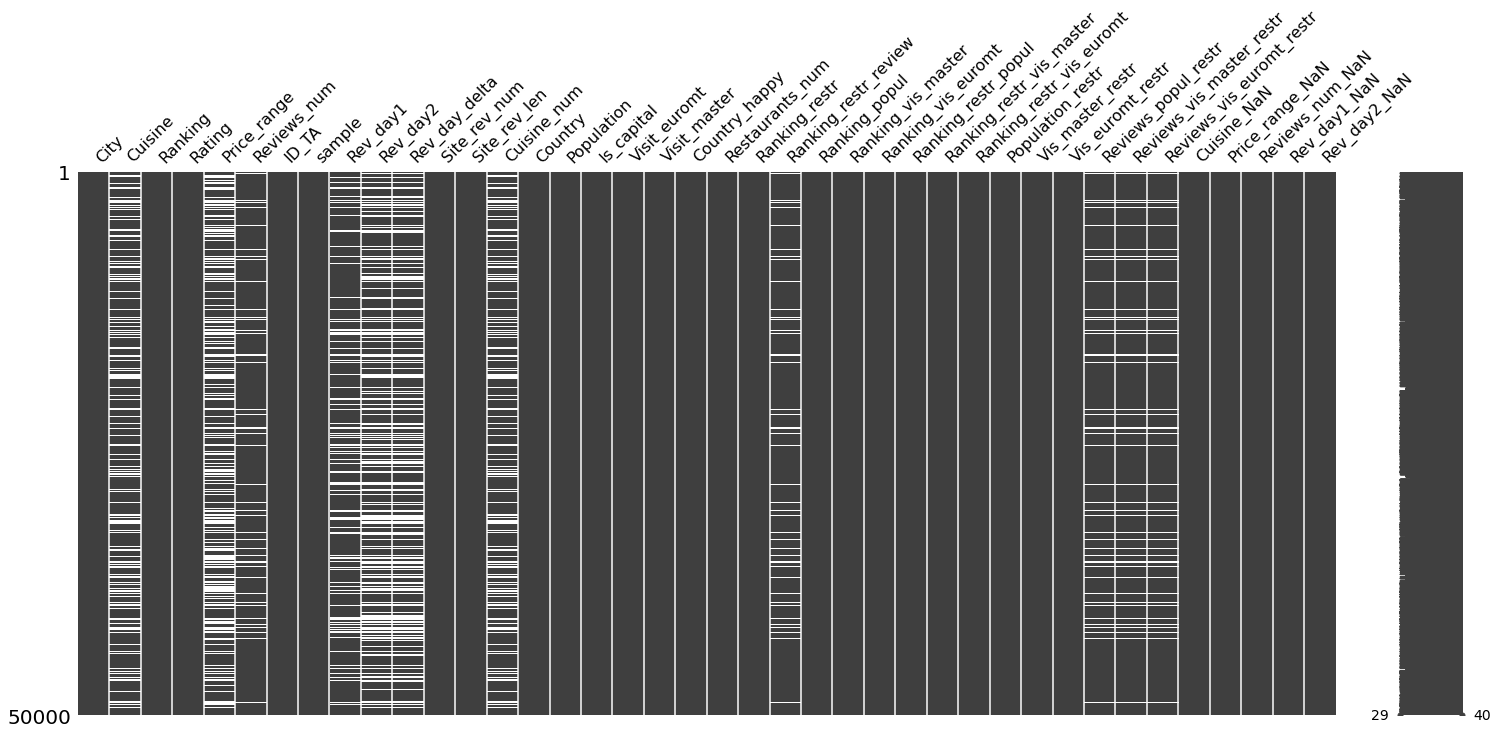

In [142]:
msno.matrix(df_join);

**Declare target variable, quantity, ordinal and categorical features**

In [143]:
# Declare target variable
target = ['Rating']

# Declare categorical features
categorical_cols = [
    'City',
    'Country',
    'Cuisine',
]

# Declare quantity features
quantity_cols = [
    'Country_happy',
    'Cuisine_num',
    'ID_TA',
    'Price_range',
    'Reviews_num',
    'Rev_day1',
    'Rev_day2',
    'Rev_day_delta',
    'Site_rev_num',
    'Site_rev_len',
    
    'Population',
    'Population_restr',
    'Ranking_popul',
    'Ranking_restr',
    'Ranking_restr_popul',
    'Ranking_restr_review',
    'Ranking_restr_vis_euromt',
    'Ranking_restr_vis_master',
    'Ranking_vis_master',
    'Ranking_vis_euromt',
    'Restaurants_num',
    'Reviews_popul_restr',
    'Reviews_vis_master_restr',
    'Reviews_vis_euromt_restr',
    'Visit_euromt',
    'Visit_master',
    'Vis_euromt_restr',
    'Vis_master_restr',
]

# Declare ordinal features
ordinal_cols = [
    'Cuisine_NaN',
    'Is_capital',
    'Price_range_NaN',
    'Reviews_num_NaN',
    'Rev_day1_NaN',
    'Rev_day2_NaN',
]

# Declare categorized quantity features
quantity_categ_cols = [
    'Ranking',
]

# Update quantity, ordinal and categorical feature lists
categorical_cols = [col for col in df_join.columns if col in categorical_cols]
quantity_cols = [col for col in df_join.columns if col in quantity_cols]
ordinal_cols = [col for col in df_join.columns if col in ordinal_cols]
quantity_categ_cols = [col for col in df_join.columns if col in quantity_categ_cols]

**View unique values**

In [144]:
# Show number of unique values of categorical features
categorical_unique = {}
for column in categorical_cols:
    categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df_join.loc[df_join[column].notna(), column].str.split('|')))).sort_values(ascending=False)
    print((column + ':').ljust(16), end='')
    print(str(len(categorical_unique[column])).rjust(6))

City:               31
Cuisine:           125
Country:            23


In [145]:
# Show unique values of categorical features
pd.set_option('display.max_rows', None)

for column in categorical_cols:
    print(column + ':')
    print(categorical_unique[column]) # in frequency order
    # print(categorical_unique[column].sort_index()) # in alphabet order
    print()
    
pd.reset_option('display.max_rows')

City:
London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
dtype: int64

Cuisine:
Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
Gluten Free Options     5185
Bar                     4094
French                  3970
Asian                   3786
Pizza                   3502
Spanish                 3456
Pub                     3058
Cafe                    2883
Fast 

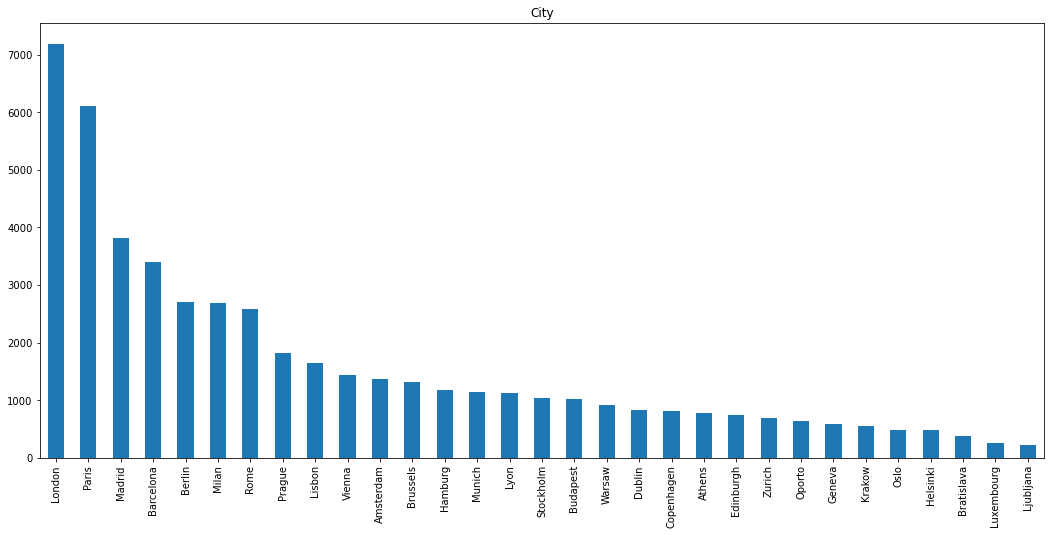

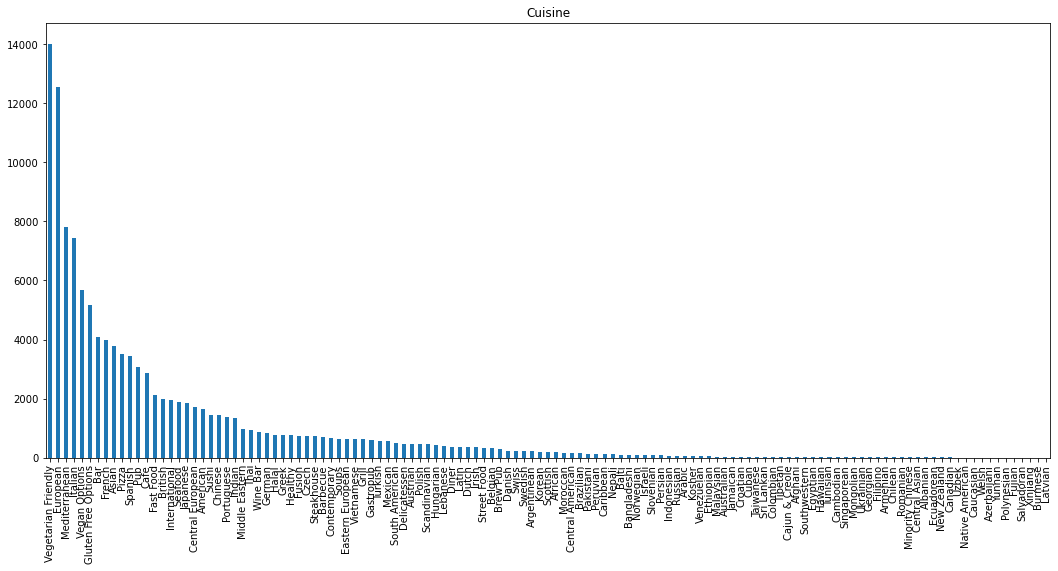

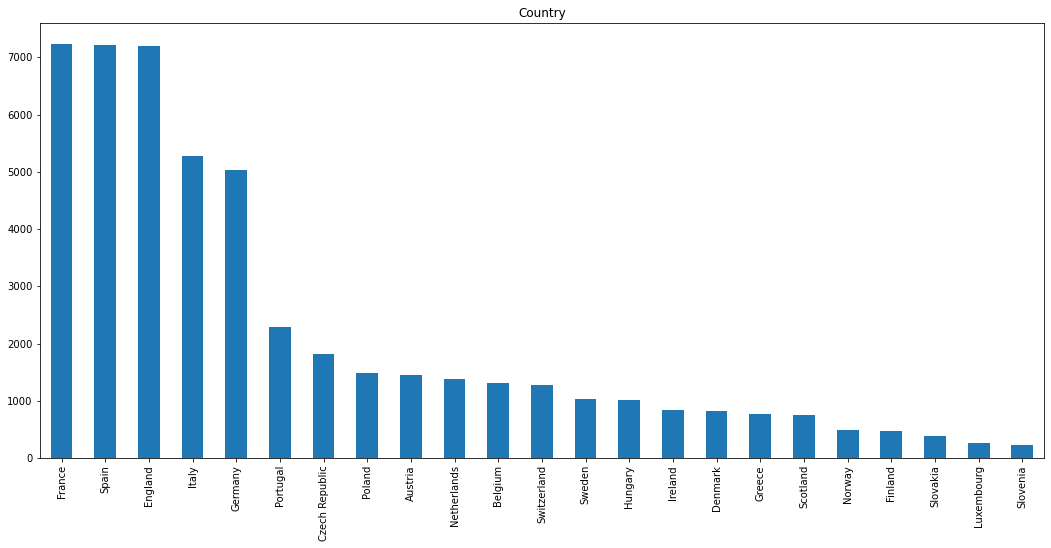

In [146]:
# Show distribution of categorical features
for column in categorical_cols:
    categorical_unique[column].plot.bar(figsize=(18, 8), title=column)
    plt.show()

    
# matplotlib realization:

# Create figure with [rows] graphs
# rows = len(categorical_cols)
# fig, axs = plt.subplots(rows, figsize=(18, rows*8))

# Plot graphs
# for i, column in enumerate(categorical_cols):
#     axs[i].bar(categorical_unique[column].index, categorical_unique[column].values)
#     axs[i].set_title(column)
#     axs[i].xaxis.set_tick_params(rotation=90)

In [147]:
# Show number of unique values of quantity and ordinal features
for column in df_join.columns:
    if df_join[column].dtype != 'O':
        print(column.join(['', ':']).ljust(16), end='')
        print(str(df_join[column].nunique()).rjust(6))

Ranking:         12975
Rating:             10
Price_range:         3
Reviews_num:      1573
ID_TA:           49963
sample:              2
Rev_day1:         2278
Rev_day2:         1575
Rev_day_delta:    1310
Site_rev_num:        3
Site_rev_len:       21
Cuisine_num:        14
Population:         31
Is_capital:          2
Visit_euromt:       28
Visit_master:       28
Country_happy:      22
Restaurants_num:    31
Ranking_restr:   49728
Ranking_restr_review: 46615
Ranking_popul:   49681
Ranking_vis_master: 48080
Ranking_vis_euromt: 49038
Ranking_restr_popul: 49997
Ranking_restr_vis_master: 49990
Ranking_restr_vis_euromt: 49992
Population_restr:    31
Vis_master_restr:    31
Vis_euromt_restr:    31
Reviews_popul_restr:  9822
Reviews_vis_master_restr:  9822
Reviews_vis_euromt_restr:  9822
Cuisine_NaN:         2
Price_range_NaN:     2
Reviews_num_NaN:     2
Rev_day1_NaN:        2
Rev_day2_NaN:        2


In [148]:
# Show unique values of quantity and ordinal features
columns = ['Rating', 'Price_range', 'Site_rev_num', 'Site_rev_len', 'Cuisine_num', 'Is_capital',
           'Cuisine_NaN', 'Price_range_NaN', 'Reviews_num_NaN', 'Rev_day1_NaN', 'Rev_day2_NaN',]

for column in df_join.columns:
    if df_join[column].dtype != 'O' and column in columns:
        print(column.join(['', ':']).ljust(16), end='')
        print(np.sort(df_join[column].unique()))

Rating:         [0.  1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Price_range:    [ 1.  2.  3. nan]
Site_rev_num:   [0 1 2]
Site_rev_len:   [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]
Cuisine_num:    [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 13. 15. 21. nan]
Is_capital:     [0 1]
Cuisine_NaN:    [0 1]
Price_range_NaN:[0 1]
Reviews_num_NaN:[0 1]
Rev_day1_NaN:   [0 1]
Rev_day2_NaN:   [0 1]


## Visualization

In [149]:
def show_boxplots(df):
    """Show boxplots of quantity and ordinal features and check them for outliers existance"""
    # Join quantity columns with target variable
    columns = sorted(quantity_cols + target)

    # Create figure with [rows x cols] graphs
    cols = 5
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*5))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
        axs[idx].boxplot(df.loc[df[column].notna(), column], showmeans=True)
        axs[idx].set_title(column)
        
        
def show_histograms(df):
    """Show distributions of quantity and ordinal features"""
    # Fill the list of bins' step if know it
    bin_step = {
        'Cuisine_num': 1,
        'Price_range': 0.5,
        'Rating': 0.5,
        'Site_rev_num': 1,
        'Site_rev_len': 0.5,
    }
    
    # Join quantity columns, ordinal columns and target variable
    columns = sorted(quantity_cols + ordinal_cols + target)

    # Create figure with [rows x cols] graphs
    cols = 4
    rows = math.ceil(len(columns)/cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(columns):
        # Calculate indices of subplots
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)

        # Calculate number of bins and ranges
        if column in bin_step.keys():
            col_max = df[column].max()
            col_min = df[column].min()
            step = bin_step[column]
            offset = step / 2
            bins = int((col_max-col_min) / step) + 1
            range_ = (col_min - offset, col_max + offset)
        elif column in ordinal_cols:
            col_max = df[column].max()
            col_min = df[column].min()
            bins = int((col_max-col_min) * 2) + 1
            range_ = (col_min - 0.25, col_max + 0.25)
        else:
            bins = 20
            range_ = None

        # Plot
        axs[idx].hist(df.loc[df[column].notna(), column], bins, range_)
        axs[idx].set_title(column)
        
        
def show_CQF_boxplots(df):
    """Show boxplots of categorized quantity features"""
    NUM_OF_VALS = 10
    CATEGORY = 'City'

    # Create figure with [rows x cols] graphs
    rows = len(quantity_categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    for i, column in enumerate(quantity_categ_cols):
        # Find masks
        categ_mask = {}
        top_categ_values = {}
        for column in quantity_categ_cols:
            # Find top NUM_OF_VALS values categorical feature
            top_categ_values[column] = categorical_unique[CATEGORY].index[:NUM_OF_VALS]

            # Find boolean masks
            categ_mask[column] = {}
            for value in top_categ_values[column]:
                categ_mask[column][value] = df[CATEGORY].str.contains(value)

        # Plot graphs
        if rows == 1:
            axs.boxplot([df.loc[categ_mask[column][value], column] for value in top_categ_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_categ_values[column], rotation=5)
        else:
            axs[i].boxplot([df.loc[categ_mask[column][value], column] for value in top_categ_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_categ_values[column], rotation=5)
            
    return (top_categ_values, categ_mask)
            
            
def show_CQF_histograms(df, top_categ_values, categ_mask):
    """Show distributions of categorized quantity features"""
    BINS = 100

    # Create figure with [rows x cols] graphs
    rows = len(quantity_categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    for i, column in enumerate(quantity_categ_cols):
        # Plot graphs
        if rows == 1:
            for value in top_categ_values[column]:
                axs.hist(df.loc[categ_mask[column][value], column], bins=BINS)
                axs.set_title(column)
        else:
            for value in top_categ_values[column]:
                axs[i].hist(df.loc[categ_mask[column][value], column], bins=BINS)
                axs[i].set_title(column)

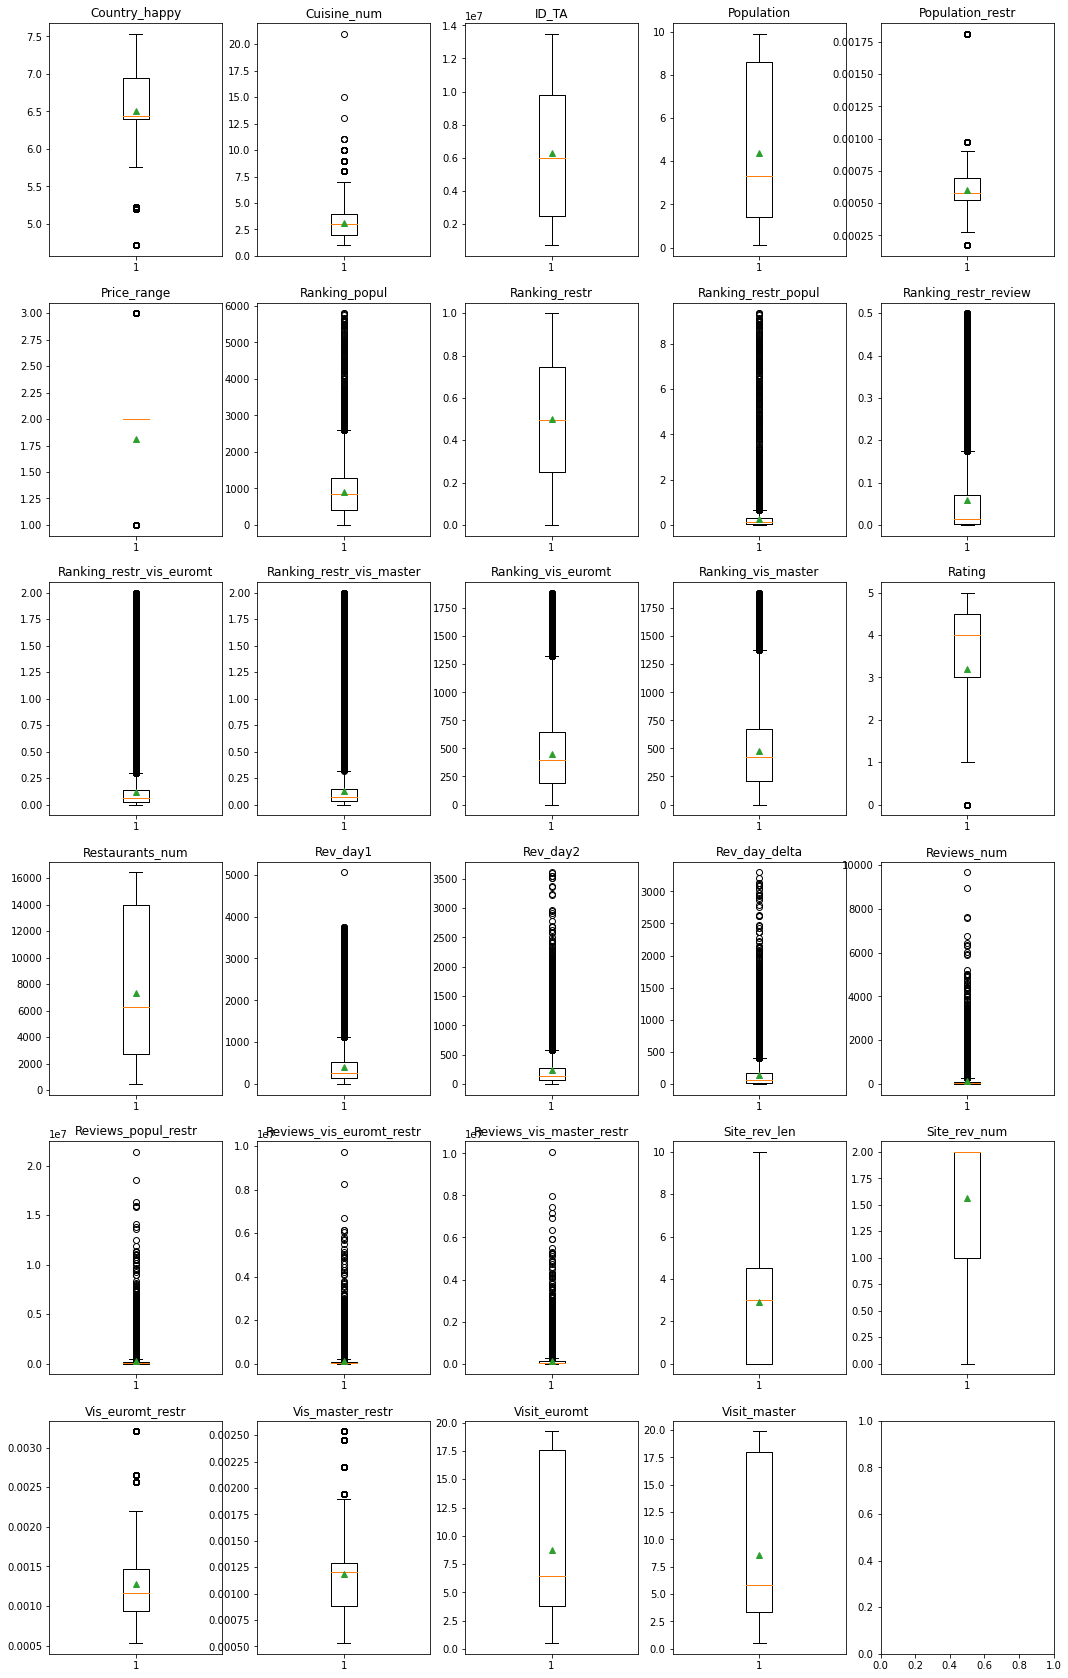

In [150]:
show_boxplots(df_join)

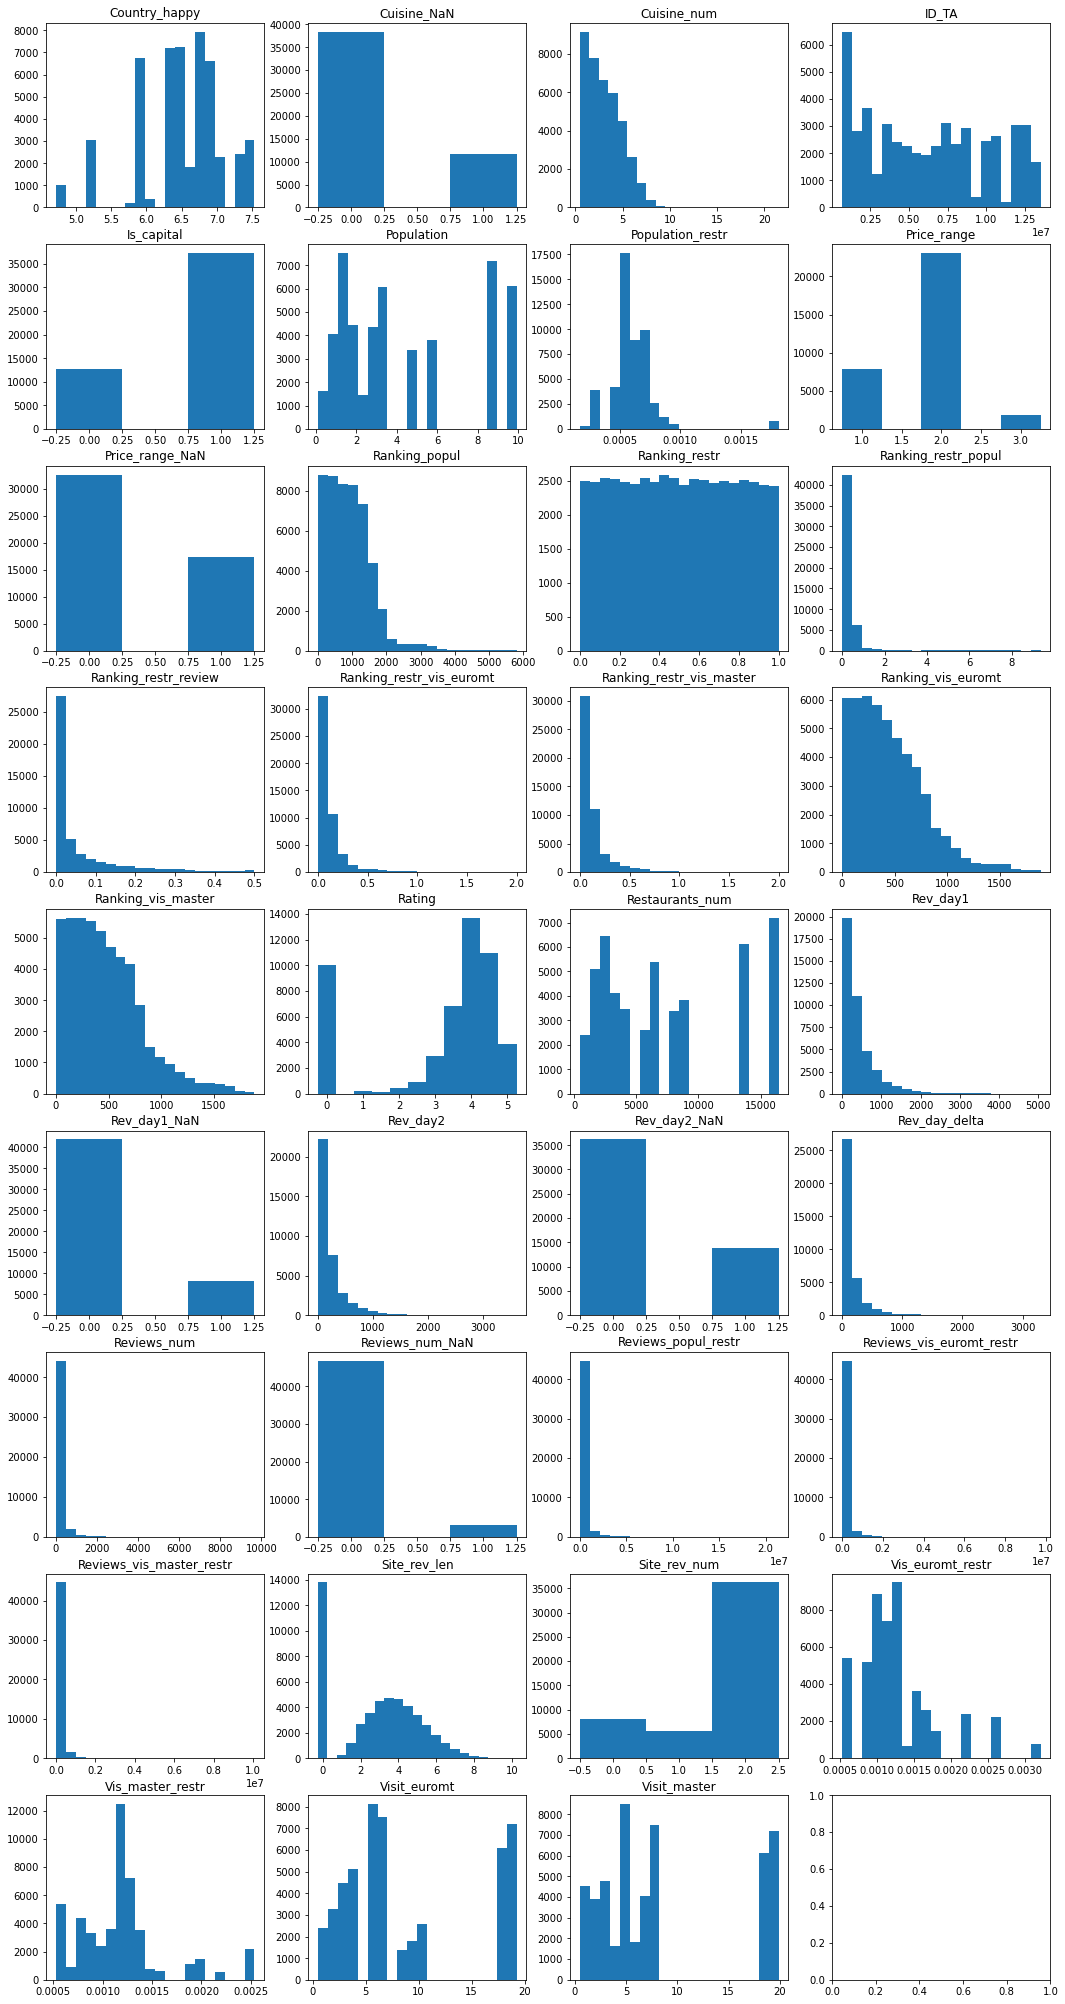

In [151]:
show_histograms(df_join)

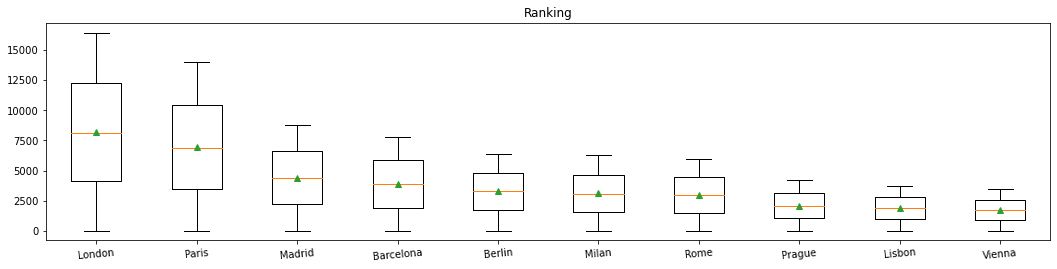

In [152]:
top_categ_values, categ_mask = show_CQF_boxplots(df_join)

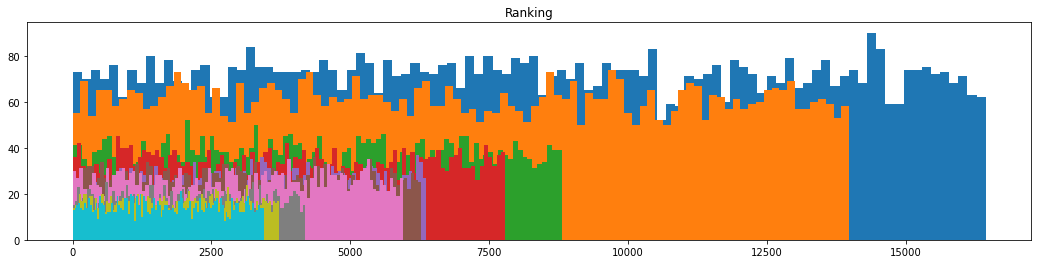

In [153]:
show_CQF_histograms(df_join, top_categ_values, categ_mask)

## Outliers handling

In [154]:
def delete_outliers(df):
    """Show number of outliers and delete rows with outliers"""
    idx_dict = {}
    for column in columns:
        # Calculate NaNs, Q1, Q3, IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate indices of rows
        idx_dict[column] = list(df.loc[(~df[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)) & (df[column].notna()), column].index)

        # Show the result
        outliers_num = len(idx_dict[column])
        if outliers_num:
            print(f"{str(outliers_num).rjust(6)} outliers are in column '{column}'")
            
    # Exclude some columns from the process
    #cols = []
    cols = ['Price_range']
    for col in df.columns:
        if col in cols:
            columns.remove(col)

    # Union indices
    idx = set()
    for column in columns:
        idx.update(idx_dict[column])

    # Drop rows with outliers
    df.drop(idx, inplace=True)
    print(f"{len(idx)} rows have been dropped")

In [155]:
# Don't delete outliers for RandomRegressionForest model
# delete_outliers(df_train)
# delete_outliers(df_test)
# delete_outliers(df_join)

## Correlation analysis
**Calculate and view correlation matrix**

In [156]:
# Calculate correlation matrix
corr_table = df_train.corr()
corr_table

,Ranking,Rating,Price_range,Reviews_num,ID_TA,sample,Rev_day1,Rev_day2,Rev_day_delta,Site_rev_num,Site_rev_len,Cuisine_num,Population,Is_capital,Visit_euromt,Visit_master,Country_happy,Restaurants_num,Ranking_restr,Ranking_restr_review,Ranking_popul,Ranking_vis_master,Ranking_vis_euromt,Ranking_restr_popul,Ranking_restr_vis_master,Ranking_restr_vis_euromt,Population_restr,Vis_master_restr,Vis_euromt_restr,Reviews_popul_restr,Reviews_vis_master_restr,Reviews_vis_euromt_restr,Cuisine_NaN,Price_range_NaN,Reviews_num_NaN,Rev_day1_NaN,Rev_day2_NaN
Ranking,1.000000,-0.368371,-0.103883,-0.222670,0.048826,NaN,0.208647,0.196224,0.137332,-0.139815,-0.124389,-0.332574,0.681709,0.224047,0.663411,0.676267,0.028551,0.709194,0.572154,0.296796,0.416962,0.410331,0.487065,-0.180921,-0.217437,-0.192704,-0.060054,-0.056513,-0.181722,-0.214141,-0.221009,-0.211393,0.147995,0.233043,0.094078,0.106386,0.148478
Rating,-0.368371,1.000000,-0.022529,0.030964,0.159111,NaN,-0.125213,-0.107185,-0.101216,0.020550,0.008526,0.143386,-0.059917,0.015475,-0.023016,-0.038701,-0.028682,-0.061097,-0.544573,-0.143953,-0.447117,-0.485282,-0.505235,-0.147408,-0.200783,-0.201404,0.027775,0.065386,0.100632,0.031432,0.024956,0.020327,-0.038263,-0.064567,0.008386,-0.024727,-0.014332
Price_range,-0.103883,-0.022529,1.000000,0.173649,-0.144948,NaN,-0.090399,-0.059183,-0.077217,0.059322,0.056996,0.156582,0.031824,0.009644,0.013005,0.020270,0.091650,0.019042,-0.187884,-0.123503,-0.170822,-0.152052,-0.146431,-0.056291,-0.061942,-0.056445,0.006733,-0.014800,-0.035470,0.158427,0.169466,0.170807,NaN,NaN,-0.038718,-0.016629,-0.080842
Reviews_num,-0.222670,0.030964,0.173649,1.000000,-0.286309,NaN,-0.231495,-0.197759,-0.172266,0.191031,0.151511,0.354874,0.015599,0.000982,0.046792,0.036775,-0.066820,0.026110,-0.399464,-0.242584,-0.325957,-0.338686,-0.332531,-0.131937,-0.177955,-0.169301,-0.038469,0.041231,0.043611,0.941668,0.945494,0.927333,-0.195070,-0.254273,NaN,-0.146297,-0.201782
ID_TA,0.048826,0.159111,-0.144948,-0.286309,1.000000,NaN,-0.178160,-0.110551,-0.119862,-0.309054,-0.270090,-0.109342,-0.055629,-0.001403,-0.072279,-0.072394,-0.075095,-0.059072,0.168795,0.302536,0.130603,0.146395,0.132006,0.054443,0.076897,0.063910,0.034619,-0.019050,0.005713,-0.267163,-0.275731,-0.272113,0.283675,0.267774,0.178326,0.245607,0.319597
sample,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rev_day1,0.208647,-0.125213,-0.090399,-0.231495,-0.178160,NaN,1.000000,0.837577,0.730876,-0.213419,-0.125710,-0.396889,-0.009239,-0.034626,-0.051224,-0.049816,-0.008899,-0.033004,0.413499,0.336577,0.309715,0.389148,0.379181,0.120003,0.183703,0.172652,0.036624,-0.076168,-0.063694,-0.218378,-0.221250,-0.218359,0.182283,0.339577,0.097198,NaN,0.213419
Rev_day2,0.196224,-0.107185,-0.059183,-0.197759,-0.110551,NaN,0.837577,1.000000,0.239298,NaN,0.041500,-0.334028,-0.000829,-0.014971,-0.029930,-0.030208,-0.008351,-0.018343,0.375400,0.334931,0.290039,0.354934,0.339625,0.115887,0.169048,0.153785,0.031420,-0.053459,-0.038451,-0.186388,-0.189207,-0.186589,0.156741,0.302901,NaN,NaN,NaN
Rev_day_delta,0.137332,-0.101216,-0.077217,-0.172266,-0.119862,NaN,0.730876,0.239298,1.000000,NaN,0.025922,-0.290157,-0.015423,-0.037047,-0.050822,-0.048861,-0.009099,-0.035827,0.287486,0.228756,0.213223,0.284307,0.278637,0.090464,0.138765,0.132941,0.028311,-0.061064,-0.055950,-0.162926,-0.163575,-0.161113,0.152920,0.235417,NaN,NaN,NaN
Site_rev_num,-0.139815,0.020550,0.059322,0.191031,-0.309054,NaN,-0.213419,NaN,NaN,1.000000,0.771263,0.309419,0.043465,0.098828,0.126016,0.121394,0.083429,0.074335,-0.372463,-0.486909,-0.263310,-0.392241,-0.391617,-0.061712,-0.125327,-0.121735,-0.029633,0.126086,0.117800,0.177240,0.184882,0.182994,-0.345486,-0.506989,-0.411012,-0.909515,-0.939501


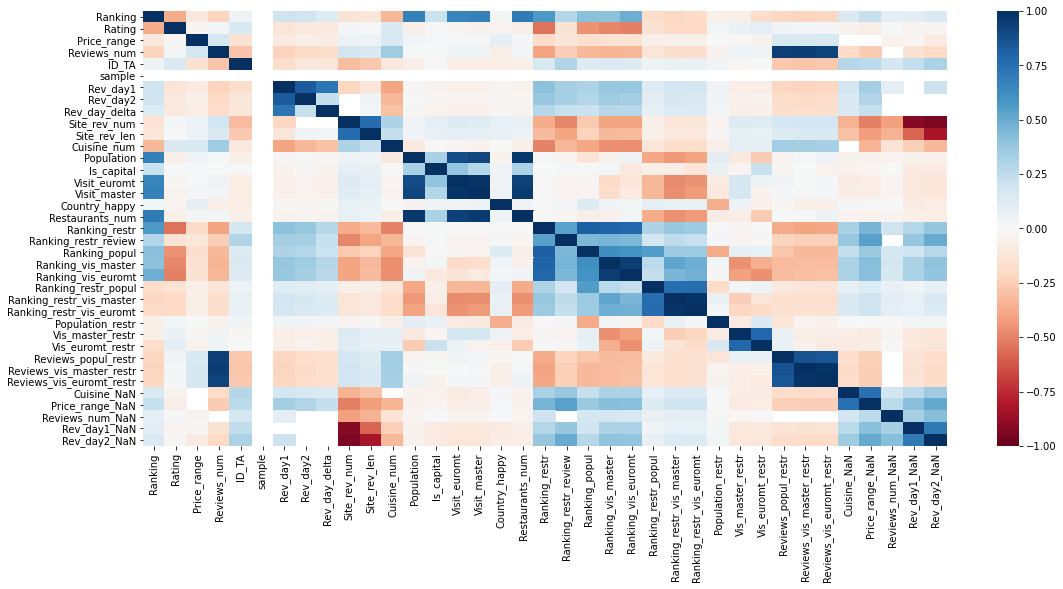

In [157]:
# Show correlation matrix
plt.subplots(figsize=(18, 8))
sns.heatmap(corr_table, vmin=-1, vmax=1, cmap="RdBu");

In [158]:
# Sort absolute correlation values with target variable
corr_table[target[0]].abs().sort_values(ascending=False)

Rating                      1.000000
Ranking_restr               0.544573
Ranking_vis_euromt          0.505235
Ranking_vis_master          0.485282
Ranking_popul               0.447117
Ranking                     0.368371
Ranking_restr_vis_euromt    0.201404
Ranking_restr_vis_master    0.200783
ID_TA                       0.159111
Ranking_restr_popul         0.147408
Ranking_restr_review        0.143953
Cuisine_num                 0.143386
Rev_day1                    0.125213
Rev_day2                    0.107185
Rev_day_delta               0.101216
Vis_euromt_restr            0.100632
Vis_master_restr            0.065386
Price_range_NaN             0.064567
Restaurants_num             0.061097
Population                  0.059917
Visit_master                0.038701
Cuisine_NaN                 0.038263
Reviews_popul_restr         0.031432
Reviews_num                 0.030964
Country_happy               0.028682
Population_restr            0.027775
Reviews_vis_master_restr    0.024956
R

**Delete proportional and highly correlated features, and also features with week correlation with target variable**

In [159]:
# Define features to delete
cols = []

# Deleting
df_train.drop(columns=[col for col in df_train.columns if col in cols], inplace=True)
df_test.drop(columns=[col for col in df_test.columns if col in cols], inplace=True)
df_join.drop(columns=[col for col in df_join.columns if col in cols], inplace=True)

# Update quantity and ordinal feature lists
quantity_cols = [col for col in df_join.columns if col in quantity_cols and col not in cols]
ordinal_cols = [col for col in df_join.columns if col in ordinal_cols and col not in cols]
quantity_categ_cols = [col for col in df_join.columns if col in quantity_categ_cols and col not in cols]

## Significance analysis of categorical features
**Hypothesis testing**

С помощью теста Стьюдента проверим есть ли статистически значимая разница в распределении целевой переменной для разных значений категориальных признаков. Проверяем нулевую гипотезу о том, что распределения целевой переменной по различным значениям категориальных переменных неразличимы.

In [160]:
def hypothesis_testing(df):
    """Hypothesis testing of significance analysis"""
    NUM_OF_VALS = 10

    # Find not significant features
    mask = {}
    top_values = {}
    not_signif_columns = []
    for column in categorical_cols:
        # Find top NUM_OF_VALS values
        top_values[column] = categorical_unique[column].index[:NUM_OF_VALS]

        # Find boolean masks
        mask[column] = {}
        for value in top_values[column]:
            mask[column][value] = (df[column].str.contains('(?:^|\|)'+value+'(?:$|\|)')) & (df[target[0]].notna())

        # Student t-test for value combinations
        combs = list(combinations(top_values[column], 2))
        for comb in combs:
            if ttest_ind(df.loc[mask[column][comb[0]], target[0]], 
                         df.loc[mask[column][comb[1]], target[0]]) \
                            .pvalue <= 0.05/len(combs): # Bonferroni correction
                break
        else:
            not_signif_columns.append(column)

    # Show result
    print('Statistically significant differences have NOT been found for columns:')
    for column in not_signif_columns:
        print(f"'{column}'")
        
    return (top_values, mask)

In [161]:
top_values, mask = hypothesis_testing(df_train)

Statistically significant differences have NOT been found for columns:


**Delete features without statistically significant difference**

In [162]:
# Define features to delete
cols = []

# Deleting
df_train.drop(columns=[col for col in df_train.columns if col in cols], inplace=True)
df_test.drop(columns=[col for col in df_test.columns if col in cols], inplace=True)
df_join.drop(columns=[col for col in df_join.columns if col in cols], inplace=True)

# Update categorical feature list
categorical_cols = [col for col in df_join.columns if col in categorical_cols and col not in cols]

**View boxplots of significant features**

In [163]:
def boxplot_significants(df, top_values, mask):
    """Show boxplots of significant features"""
    # Create figure with [rows x cols] graphs
    rows = len(categorical_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(categorical_cols):
        if rows == 1:
            axs.boxplot([df.loc[mask[column][value], target[0]] for value in top_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_values[column], rotation=5)
            axs.set_ylabel(target[0])
        else:
            axs[i].boxplot([df.loc[mask[column][value], target[0]] for value in top_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_values[column], rotation=5)
            axs[i].set_ylabel(target[0])

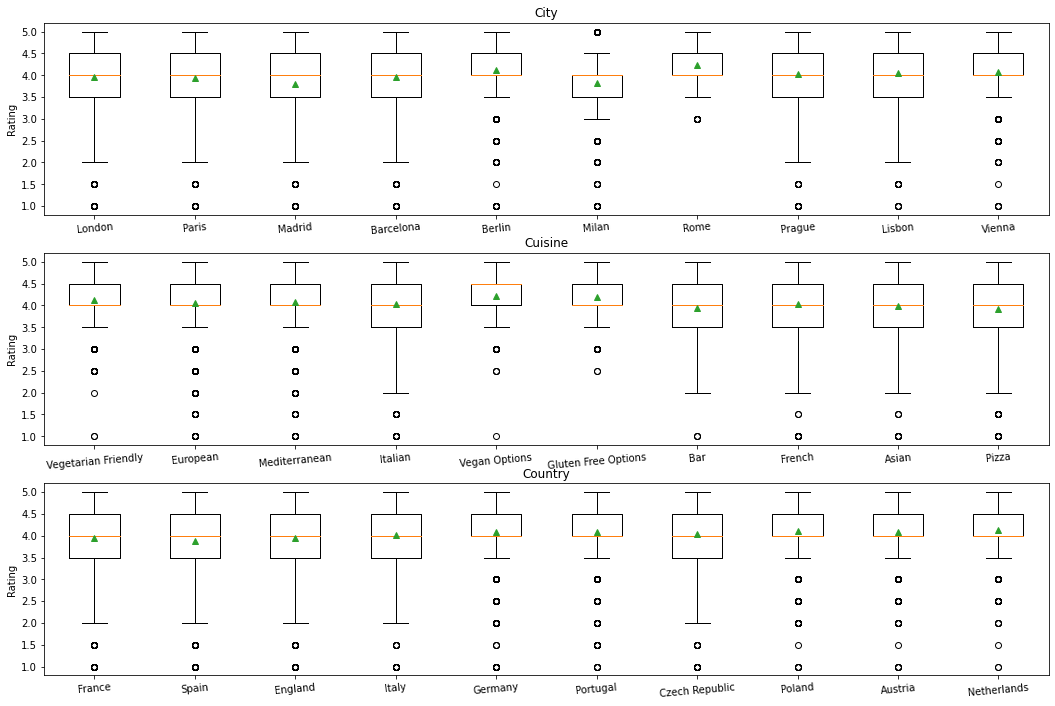

In [164]:
boxplot_significants(df_train, top_values, mask)

## Missing values handling

In [165]:
def fill_missing_values(df):
    # Fill missing values of quantity and ordinal features

    # Drop rows with missing values of target variable
    print(f"{df[target[0]].isna().sum()} rows have been dropped of missed target")
    df.dropna(subset=[target[0]], inplace=True)

    # Use a function to calc values to replace NaNs
    func = ['mean'] # Use list-like value to speed up calc

    # Calculate values
    replace_vals = df.agg(func)

    for column in quantity_cols + ordinal_cols:
        # Show the result
        print(f"{str(df[column].isna().sum()).rjust(6)} NaN have been replaced in column '{column}'")

        # Replace missing values
        if column == 'Price_range':
            df[column].fillna(2, inplace=True)
        elif column == 'Reviews_num':
            df[column].fillna(0, inplace=True)
#             values = df.groupby('City')['Reviews_num'].mean().round()
#             df['zzz'] = df['City'].map(values)
#             idx = df['Reviews_num'].isna()
#             df.loc[idx, 'Reviews_num'] = df.loc[idx, 'zzz']
#             df.drop('zzz', axis=1, inplace=True)
        else:
            df[column].fillna(0, inplace=True)
#             df[column].fillna(replace_vals[column][0], inplace=True)
        
        
    # Fill missing values of categorical features
    
    for column in categorical_cols:
        # Show the result
        print(f"{str(df[column].isna().sum()).rjust(6)} NaN have been replaced in column '{column}'")
        
        # Find value for replasing
        values_num = round(df.loc[df[column].notna(), column].apply(lambda x: len(x.split('|'))).mean())
        value = '|'.join(categorical_unique[column].index[:values_num])

        # Replace missing values
        df[column].fillna(value, inplace=True)

**Fill missing values**

In [166]:
fill_missing_values(df_train)
print()
fill_missing_values(df_test)
print()
fill_missing_values(df_join)

0 rows have been dropped of missed target
 13886 NaN have been replaced in column 'Price_range'
  2543 NaN have been replaced in column 'Reviews_num'
     0 NaN have been replaced in column 'ID_TA'
  6471 NaN have been replaced in column 'Rev_day1'
 11027 NaN have been replaced in column 'Rev_day2'
 11027 NaN have been replaced in column 'Rev_day_delta'
     0 NaN have been replaced in column 'Site_rev_num'
     0 NaN have been replaced in column 'Site_rev_len'
  9283 NaN have been replaced in column 'Cuisine_num'
     0 NaN have been replaced in column 'Population'
     0 NaN have been replaced in column 'Visit_euromt'
     0 NaN have been replaced in column 'Visit_master'
     0 NaN have been replaced in column 'Country_happy'
     0 NaN have been replaced in column 'Restaurants_num'
     0 NaN have been replaced in column 'Ranking_restr'
  2543 NaN have been replaced in column 'Ranking_restr_review'
     0 NaN have been replaced in column 'Ranking_popul'
     0 NaN have been replace

## Dummies generation

In [167]:
def generate_dummies(df):
    """Dummies generation from categorical features"""
    # Generate dummies
    df_out = df
    for column in categorical_cols:
        df_out = pd.concat([df_out, df[column].str.get_dummies()], axis=1)

    # Drop categorical columns
    df_out.drop(categorical_cols, axis=1, inplace=True)
    
    return df_out

**Generate dummies**

In [168]:
# df_train = generate_dummies(df_train)
# df_test = generate_dummies(df_test)
# df_join = generate_dummies(df_join)

# Model implementation

## Split data: features & target; train & test

In [169]:
def split_dataframe(df, test_size):
    """Split dataframe to: X, X_train, X_test, y, y_train, y_test"""
    # Split data: Х - features, у - target variable
    y = df.loc[df['sample'] == 1, target[0]].values
    X = df.loc[df['sample'] == 1].drop(['sample', target[0]], axis=1)

    # Split data on train and test parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_SEED)

    return (X, X_train, X_test, y, y_train, y_test)

## Create and learn model

In [170]:
def create_and_learn_model(X_train, y_train):
    # Create model
    model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

    # Learn model on the train set
    model.fit(X_train, y_train)
    
    return model

## Test model

In [171]:
def test_model(model, X_test, y_test):
    """Test model and return metric"""
    # Predict target variable
    y_pred = model.predict(X_test)
    
    # Postprocess the data: round to 0.5
    y_pred = (y_pred*2).round() / 2
    
    # Return prediction and metric: Mean Absolute Error (MAE)
    return metrics.mean_absolute_error(y_test, y_pred)

## Tune features

In [172]:
def train_test_vs_sample_value():
    """Plot train and test graphs versus sample value
    in order to detect high bias or high variance.
    Also helps to find optimum sample value to fit model for tuning.
    """
    # Split data
    X, X_train, X_test, y, y_train, y_test = split_dataframe(data, test_size=0.3)

    # Save data
    X_train_temp = X_train.copy()
    X_test_temp = X_test.copy()
    y_train_temp = y_train.copy()
    y_test_temp = y_test.copy()

    mae_train = []
    mae_test = []
    for i in range(100):
        START = 500
        STEP = 500

        stop = START+STEP*i
        if stop <= y_train.shape[0]:
            XX_train = X_train[:stop]
            yy_train = y_train[:stop]

            # Print an intermediate result
            print("Iteration =", i, '; Data length =', XX_train.shape[0])

            # Create and learn model
            model = create_and_learn_model(XX_train, yy_train)

            # Test model
            mae_train.append(test_model(model, XX_train, yy_train))
            mae_test.append(test_model(model, X_test, y_test))

    mae = pd.DataFrame.from_dict({'train': mae_train, 'test': mae_test})
    mae.plot(title='Train and test MAE vs sample value')

In [173]:
def find_usefull_useless_feature(data, test_size, usefull_cols=None):
    """Find the most usefull or useless feature.
    
    Find the most usefull feature to add if 'usefull_cols' is a list.
    Find the most useless feature to drop if 'usefull_cols' is None.
    """
    # Split data
    X, X_train, X_test, y, y_train, y_test = split_dataframe(data, test_size=test_size)

    # Determine columns list
    if usefull_cols is not None:
        columns = [col for col in X_train.columns if col not in usefull_cols]
    else:
        columns = X_train.columns # [0:110]
    
    # Find feature
    features_mae = pd.DataFrame(columns=['feature', 'MAE_test', 'MAE_train'])
    for i, column in enumerate(columns):
        # Define train and test data
        if usefull_cols is not None:
            # Retrieve data
            cols = usefull_cols.copy()
            cols.append(column)
            X_train_temp = X_train[cols]
            X_test_temp = X_test[cols]
        
        else:
            # Retrieve data
            X_train_temp = X_train.drop(column, axis=1)
            X_test_temp = X_test.drop(column, axis=1)

        # Create and learn model
        model = create_and_learn_model(X_train_temp, y_train)

        # Test model
        mae_train = test_model(model, X_train_temp, y_train)
        mae_test = test_model(model, X_test_temp, y_test)

        # Save metric: Mean Absolute Error (MAE)
        features_mae = features_mae.append({'feature': column, 'MAE_test': mae_test, 'MAE_train': mae_train}, ignore_index=True)
        
        # Print an intermediate result
        print('Iteration =', i)
        print(features_mae.nsmallest(1, 'MAE_test'))

    return features_mae.sort_values('MAE_test', ascending=True, ignore_index=True)

In [174]:
def find_several_usefull_useless_features(data, features_num, test_size, usefull_cols=None):
    """Find several usefull of useless features at a time.
    
    Find the most usefull features to add if 'usefull_cols' is a list.
    Find the most useless features to drop if 'usefull_cols' is None.
    """
    if usefull_cols is not None:
        data_temp = data[usefull_cols].copy()
    else:
        data_temp = data.copy()
    
    # Find features
    features_mae = pd.DataFrame(columns=['feature', 'MAE_test', 'MAE_train'])
    for i in range(features_num):
        if usefull_cols is not None:
            # Find usefull feature and add it
            df_mae = find_usefull_useless_feature(data=data, test_size=test_size, usefull_cols=usefull_cols)
            usefull_cols.append(df_mae.iloc[0, 0])
            data_temp = pd.concat([data_temp, data[df_mae.iloc[0, 0]]], axis=1)
        else:
            # Find useless feature and drop it
            df_mae = find_usefull_useless_feature(data=data_temp, test_size=test_size)
            data_temp.drop(df_mae.iloc[0, 0], axis=1, inplace=True)

        # Print an intermediate result
        features_mae = features_mae.append(df_mae.iloc[0], ignore_index=True)
        features_mae.to_csv('features_mae.csv')
        print('Feature number =', i)
        print(features_mae)
        
    return features_mae.sort_values('MAE_test', ascending=True, ignore_index=True)

Prepare data

In [175]:
# Prepare data
df_train, df_test, data, sample_submission = collect_data('/kaggle/input/sf-dst-restaurant-rating/')
format_dataset(data)
create_new_features(data)
delete_useless_features(data)
dirty_handling(data)
fill_missing_values(data)
data = generate_dummies(data)

0 rows have been dropped of missed target
 17361 NaN have been replaced in column 'Price_range'
  3200 NaN have been replaced in column 'Reviews_num'
     0 NaN have been replaced in column 'ID_TA'
  8114 NaN have been replaced in column 'Rev_day1'
 13794 NaN have been replaced in column 'Rev_day2'
 13794 NaN have been replaced in column 'Rev_day_delta'
     0 NaN have been replaced in column 'Site_rev_num'
     0 NaN have been replaced in column 'Site_rev_len'
 11590 NaN have been replaced in column 'Cuisine_num'
     0 NaN have been replaced in column 'Population'
     0 NaN have been replaced in column 'Visit_euromt'
     0 NaN have been replaced in column 'Visit_master'
     0 NaN have been replaced in column 'Country_happy'
     0 NaN have been replaced in column 'Restaurants_num'
     0 NaN have been replaced in column 'Ranking_restr'
  3200 NaN have been replaced in column 'Ranking_restr_review'
     0 NaN have been replaced in column 'Ranking_popul'
     0 NaN have been replace

Tune features

Iteration = 0 ; Data length = 500


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Iteration = 1 ; Data length = 1000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 2 ; Data length = 1500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 3 ; Data length = 2000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 4 ; Data length = 2500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 5 ; Data length = 3000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 6 ; Data length = 3500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 7 ; Data length = 4000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 8 ; Data length = 4500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 9 ; Data length = 5000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 10 ; Data length = 5500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 11 ; Data length = 6000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 12 ; Data length = 6500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 13 ; Data length = 7000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 14 ; Data length = 7500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 15 ; Data length = 8000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 16 ; Data length = 8500


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 17 ; Data length = 9000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 18 ; Data length = 9500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 19 ; Data length = 10000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 20 ; Data length = 10500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 21 ; Data length = 11000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 22 ; Data length = 11500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 23 ; Data length = 12000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 24 ; Data length = 12500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 25 ; Data length = 13000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 26 ; Data length = 13500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 27 ; Data length = 14000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 28 ; Data length = 14500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 29 ; Data length = 15000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 30 ; Data length = 15500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 31 ; Data length = 16000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 32 ; Data length = 16500


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 33 ; Data length = 17000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 34 ; Data length = 17500


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 35 ; Data length = 18000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 36 ; Data length = 18500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 37 ; Data length = 19000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 38 ; Data length = 19500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 39 ; Data length = 20000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 40 ; Data length = 20500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 41 ; Data length = 21000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 42 ; Data length = 21500


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 43 ; Data length = 22000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 44 ; Data length = 22500


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 45 ; Data length = 23000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 46 ; Data length = 23500


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 47 ; Data length = 24000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 48 ; Data length = 24500


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 49 ; Data length = 25000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 50 ; Data length = 25500


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 51 ; Data length = 26000


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 52 ; Data length = 26500


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 53 ; Data length = 27000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Iteration = 54 ; Data length = 27500


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Iteration = 55 ; Data length = 28000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


CPU times: user 53min 17s, sys: 4.6 s, total: 53min 22s
Wall time: 13min 56s


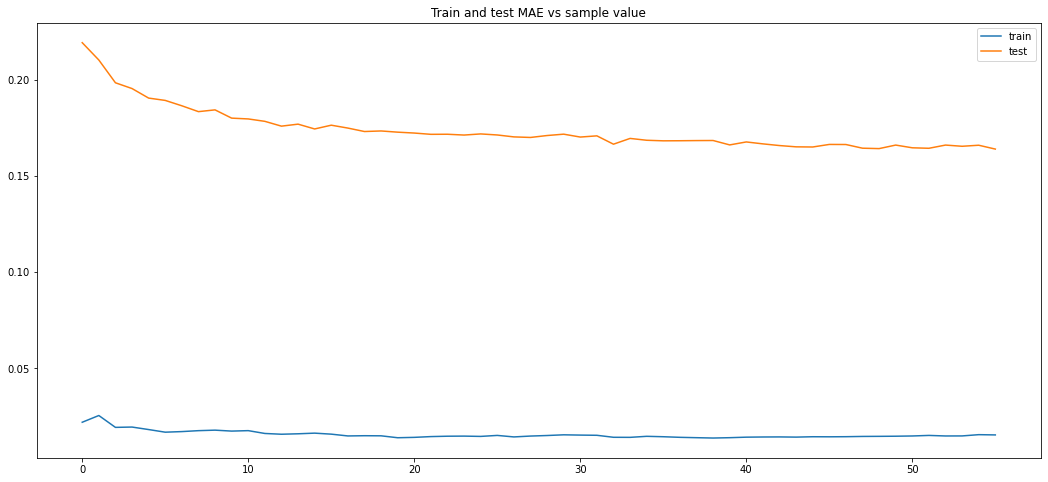

In [176]:
%%time
# Plot train and test versus sample value
# to define whether the model has high bias or high variance
# and find optimum train-test sample proportion to tune features
train_test_vs_sample_value()

The sample value of 10000 for train set is the best to find usefull features

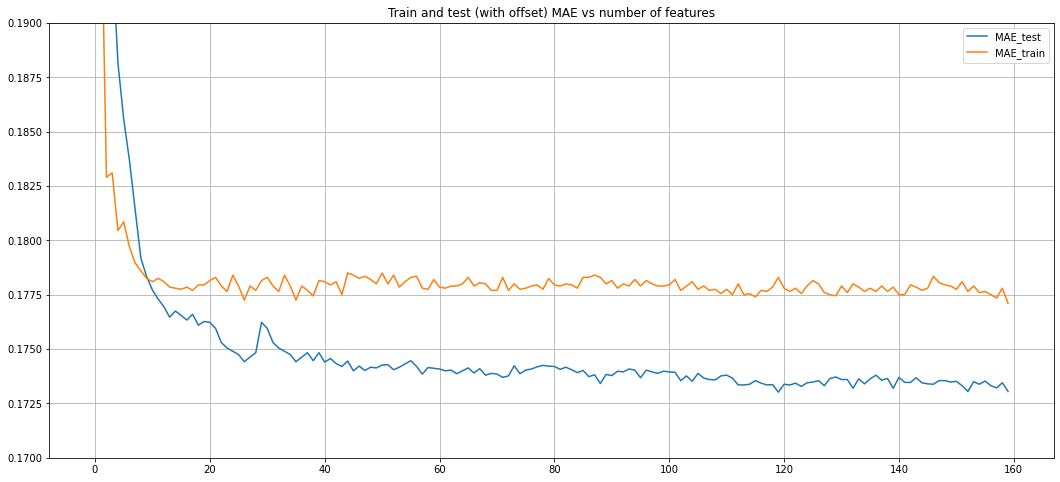

In [177]:
# Already found usefull features
usefull_cols = [
    'Ranking_restr', 'Reviews_vis_master_restr', 'Vis_master_restr',
    'Rev_day1', 'Vis_euromt_restr', 'Ranking_restr_vis_euromt',
    'ID_TA', 'Rome', 'Edinburgh', 'Ranking_restr_vis_master',
    'Germany', 'Price_range_NaN', 'Portugal', 'Caucasian',
    'Population', 'Balti', 'Warsaw', 'Oporto', 'Peruvian', 'Swedish',
    'Rev_day2', 'Reviews_num', 'Belgian', 'Tibetan', 'Bar', 'Chinese',
    'Cuisine_num', 'Pakistani', 'Portuguese', 'Rev_day2',
    'Reviews_num', 'Belgian', 'Tibetan', 'Bar', 'Chinese',
    'Cuisine_num', 'Pakistani', 'Portuguese', 'Central American',
    'Site_rev_len', 'Burmese', 'Middle Eastern', 'Rev_day2_NaN',
    'Ljubljana', 'Berlin', 'Delicatessen', 'Munich', 'Ethiopian',
    'Turkish', 'Colombian', 'Slovenian', 'Venezuelan', 'Copenhagen',
    'Yunnan', 'Swiss', 'Helsinki', 'Taiwanese', 'Milan', 'Hungarian',
    'Healthy', 'Wine Bar', 'Armenian', 'Luxembourg', 'Danish',
    'Argentinean', 'Vietnamese', 'Slovenia', 'Uzbek', 'German',
    'Cajun & Creole', 'Singaporean', 'Seafood', 'Vegan Options',
    'Minority Chinese', 'Filipino', 'Cuisine_NaN', 'Nepali', 'Dublin',
    'Moroccan', 'Diner', 'Denmark', 'Persian', 'Steakhouse', 'Prague',
    'Population_restr', 'Cuban', 'Scottish', 'French', 'Halal',
    'Norwegian', 'Belgium', 'Pizza', 'International', 'Malaysian',
    'Visit_euromt', 'Romanian', 'Greek', 'Site_rev_num', 'Zurich',
    'Czech', 'Hamburg', 'Restaurants_num', 'Grill', 'Lyon',
    'Brazilian', 'South American', 'Vegetarian Friendly',
    'Southwestern', 'Indonesian', 'Switzerland', 'Albanian', 'Lisbon',
    'Sweden', 'Salvadoran', 'France', 'Austrian', 'Poland',
    'Netherlands', 'Visit_master', 'Eastern European', 'Canadian',
    'Korean', 'Polish', 'Stockholm', 'Cafe', 'Vienna', 'Dutch',
    'Caribbean', 'Brew Pub', 'Finland', 'Hawaiian', 'Amsterdam',
    'London', 'Geneva', 'Hungary', 'Austria', 'Thai', 'Greece',
    'Russian', 'Australian', 'American', 'Price_range',
    'Rev_day_delta', 'Spain', 'Italy', 'Reviews_num_NaN',
    'Czech Republic', 'Oslo', 'Fusion', 'Afghani', 'Lebanese',
    'England', 'Mongolian', 'Ecuadorean', 'Tunisian', 'Norway',
    'Barcelona', 'Azerbaijani', 'Bangladeshi', 'Central Asian'
]

# Fine next usefull features
# %time find_several_usefull_useless_features(data, features_num=50, test_size=30000, usefull_cols=usefull_cols)

# Usefull features rank:
features_mae = \
"""number           feature  MAE_test  MAE_train
0             Ranking_restr  0.415533  0.10320
1  Reviews_vis_master_restr  0.237283  0.03690
2          Vis_master_restr  0.199250  0.02290
3                  Rev_day1  0.193367  0.02310
4          Vis_euromt_restr  0.188150  0.02045
5  Ranking_restr_vis_euromt  0.185583  0.02085
6                     ID_TA  0.183683  0.01970
7                      Rome  0.181400  0.01895
8                 Edinburgh  0.179167  0.01860
9  Ranking_restr_vis_master  0.178333  0.01825
10                  Germany  0.177717  0.01810
11          Price_range_NaN  0.177300  0.01825
12                 Portugal  0.176950  0.01810
13                Caucasian  0.176467  0.01785
14               Population  0.176750  0.01780
15                    Balti  0.176550  0.01775
16                   Warsaw  0.176333  0.01785
17                   Oporto  0.176600  0.01770
18                 Peruvian  0.176100  0.01795
19                  Swedish  0.176267  0.01795
20                 Rev_day2  0.176233  0.01815
21              Reviews_num  0.175950  0.01830
22                  Belgian  0.175300  0.01790
23                  Tibetan  0.175050  0.01765
24                      Bar  0.174900  0.01840
25                  Chinese  0.174750  0.01790
26              Cuisine_num  0.174417  0.01725
27                Pakistani  0.174633  0.01790
28               Portuguese  0.174833  0.01770
29                 Rev_day2  0.176233  0.01815
30              Reviews_num  0.175950  0.01830
31                  Belgian  0.175300  0.01790
32                  Tibetan  0.175050  0.01765
33                      Bar  0.174900  0.01840
34                  Chinese  0.174750  0.01790
35              Cuisine_num  0.174417  0.01725
36                Pakistani  0.174630  0.01790
37               Portuguese  0.174833  0.01770
38         Central American  0.174467  0.01745
39             Site_rev_len  0.174833  0.01815
40                  Burmese  0.174400  0.01810
41           Middle Eastern  0.174567  0.01795
42             Rev_day2_NaN  0.174333  0.01810
43                Ljubljana  0.174200  0.01750
44                   Berlin  0.174450  0.01850
45             Delicatessen  0.174000  0.01840
46                   Munich  0.174217  0.01825
47                Ethiopian  0.174017  0.01835
48                  Turkish  0.174167  0.01820
49                Colombian  0.174133  0.01800
50                Slovenian  0.174267  0.01850
51               Venezuelan  0.174283  0.01800
52               Copenhagen  0.174050  0.01840
53                   Yunnan  0.174167  0.01785
54                    Swiss  0.174317  0.01810
55                 Helsinki  0.174467  0.01830
56                Taiwanese  0.174200  0.01835
57                    Milan  0.173850  0.01780
58                Hungarian  0.174150  0.01775
59                  Healthy  0.174117  0.01820
60                 Wine Bar  0.174083  0.01785
61                 Armenian  0.174000  0.01780
62               Luxembourg  0.174033  0.01790
63                   Danish  0.173867  0.01790
64              Argentinean  0.174000  0.01800
65               Vietnamese  0.174133  0.01830
66                 Slovenia  0.173900  0.01790
67                    Uzbek  0.174100  0.01805
68                   German  0.173800  0.01800
69           Cajun & Creole  0.173883  0.01770
70              Singaporean  0.173850  0.01770
71                  Seafood  0.173700  0.01830
72            Vegan Options  0.173767  0.01770
73         Minority Chinese  0.174233  0.01800
74                 Filipino  0.173867  0.01775
75              Cuisine_NaN  0.174033  0.01780
76                   Nepali  0.174083  0.01790
77                   Dublin  0.174183  0.01795
78                 Moroccan  0.174250  0.01775
79                    Diner  0.174217  0.01825
80                  Denmark  0.174200  0.01795
81                  Persian  0.174067  0.01790
82               Steakhouse  0.174167  0.01800
83                   Prague  0.174050  0.01795
84         Population_restr  0.173917  0.01780
85                    Cuban  0.174017  0.01830
86                 Scottish  0.173733  0.01830
87                   French  0.173817  0.01840
88                    Halal  0.173417  0.01830
89                Norwegian  0.173833  0.01800
90                  Belgium  0.173783  0.01815
91                    Pizza  0.173983  0.01780
92            International  0.173950  0.01800
93                Malaysian  0.174083  0.01790
94             Visit_euromt  0.174033  0.01820
95                 Romanian  0.173683  0.01790
96                    Greek  0.174033  0.01815
97             Site_rev_num  0.173950  0.01800
98                   Zurich  0.173883  0.01790
99                    Czech  0.173983  0.01790
100                 Hamburg  0.173950  0.01795
101         Restaurants_num  0.173933  0.01820
102                   Grill  0.173550  0.01770
103                    Lyon  0.173767  0.01790
104               Brazilian  0.173517  0.01810
105          South American  0.173883  0.01775
106     Vegetarian Friendly  0.173667  0.01790
107            Southwestern  0.173600  0.01770
108              Indonesian  0.173583  0.01775
109             Switzerland  0.173767  0.01755
110                Albanian  0.173800  0.01775
111                  Lisbon  0.173667  0.01750
112                  Sweden  0.173350  0.01800
113              Salvadoran  0.173350  0.01750
114                  France  0.173383  0.01755
115                Austrian  0.173550  0.01740
116                  Poland  0.173433  0.01770
117             Netherlands  0.173350  0.01765
118            Visit_master  0.173367  0.01785
119        Eastern European  0.173017  0.01830
120                Canadian  0.173383  0.01780
121                  Korean  0.173350  0.01765
122                  Polish  0.173433  0.01780
123               Stockholm  0.173283  0.01755
124                    Cafe  0.173450  0.01790
125                  Vienna  0.173483  0.01815
126                   Dutch  0.173550  0.01800
127               Caribbean  0.173317  0.01760
128                Brew Pub  0.173650  0.01750
129                 Finland  0.173717  0.01745
130                Hawaiian  0.173600  0.01790
131               Amsterdam  0.173600  0.01760
132                  London  0.173200  0.01800
133                  Geneva  0.173633  0.01785
134                 Hungary  0.173400  0.01765
135                 Austria  0.173633  0.01780
136                    Thai  0.173800  0.01765
137                  Greece  0.173567  0.01790
138                 Russian  0.173650  0.01765
139              Australian  0.173200  0.01785
140                American  0.173700  0.01750
141             Price_range  0.173467  0.01750
142           Rev_day_delta  0.173467  0.01795
143                   Spain  0.173683  0.01785
144                   Italy  0.173450  0.01770
145         Reviews_num_NaN  0.173400  0.01780
146          Czech Republic  0.173383  0.01835
147                    Oslo  0.173550  0.01805
148                  Fusion  0.173550  0.01795
149                 Afghani  0.173483  0.01790
150                Lebanese  0.173517  0.01775
151                 England  0.173317  0.01810
152               Mongolian  0.173050  0.01765
153              Ecuadorean  0.173500  0.01790
154                Tunisian  0.173383  0.01760
155                  Norway  0.173533  0.01765
156               Barcelona  0.173317  0.01750
157             Azerbaijani  0.173217  0.01735
158             Bangladeshi  0.173450  0.01780
159           Central Asian  0.173050  0.01710
"""

# Plot train and test versus number of features
features_mae = re.sub('\s{2,}', ',', features_mae)
features_mae = StringIO(features_mae)
features_mae = pd.read_csv(features_mae)
features_mae['MAE_train'] = features_mae['MAE_train'] + 0.16
features_mae[['MAE_test', 'MAE_train']].plot(figsize=(18, 8), grid=True, ylim=(0.17, 0.19),
                                             title='Train and test (with offset) MAE vs number of features');
#features_mae['feature'].values

Test model

Shapes: (40000, 161) (32000, 161) (8000, 161) (40000,) (32000,) (8000,)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


MAE =  0.160625


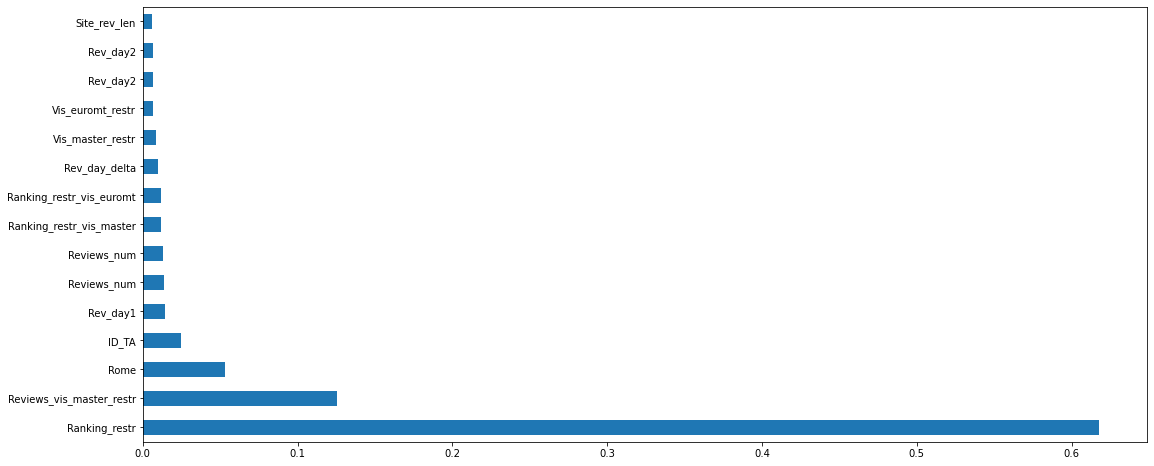

In [178]:
# Pick out only usefull features
usefull_cols += [target[0], 'sample']
data = data.loc[:, usefull_cols]

# Split data
X, X_train, X_test, y, y_train, y_test = split_dataframe(data, test_size=0.2)

# Check data dimensions
print('Shapes:', X.shape, X_train.shape, X_test.shape, y.shape, y_train.shape, y_test.shape)

# Create and learn model
model = create_and_learn_model(X_train, y_train)

# View important model characteristics
plt.rcParams['figure.figsize'] = (18, 8)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

# Test model
mae = test_model(model, X_test, y_test)
print('MAE = ', mae)

# Submission
**Learn model on 100% of train data**

In [179]:
# Create and learn model
model = create_and_learn_model(X, y)

# Predict target variable
predict_submission = model.predict(data.loc[data['sample'] == 0].drop(['sample', target[0]], axis=1))

# Round to 0.5
predict_submission = (predict_submission*2).round() / 2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


**Write result to submission file**

In [180]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.0


# What's next?
Или, что делать, чтобы улучшить результат:

- Обработать оставшиеся признаки в понятный для машины формат
- Посмотреть, что еще можно извлечь из признаков
- Сгенерировать новые признаки
- Подгрузить дополнительные данные, например: по населению или благосостоянию городов
- Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!